# Berater Environment v13 (Orso's live)

## Changes from v12 (work in progress)
* migration to easyagents
* Max. number of steps management and debug logging migrated to easyagents.TrainingDuration
* render yields the last step, supporting modes 'ansi', 'human', 'rgb_array'
* the story of Orso

### Install gym, tensorflow, tf-agents,..., setup display

In [1]:
!pip install easyagents > /dev/null
!pip install networkx==2.3.0 > /dev/null

import sys

if 'google.colab' in sys.modules:
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start()  

# Define Gym Environment

### Imports

In [26]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

import gym
from gym.utils import seeding
from gym import spaces

import pdb

### Helper methods

In [27]:
def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]

### Berater Environment (OpenAI Gym)

In [37]:
class BeraterEnv(gym.Env):
    """
    The Berater Problem

    Actions:
    There are 4 discrete deterministic actions, each choosing one direction
    """
    metadata = {'render.modes': ['ansi']}
    showStep = False

    def __init__(self):
        #         self.map = {
        #             'S': [('A', 100), ('B', 400), ('C', 200 )],
        #             'A': [('B', 250), ('C', 400), ('S', 100 )],
        #             'B': [('A', 250), ('C', 250), ('S', 400 )],
        #             'C': [('A', 400), ('B', 250), ('S', 200 )]
        #         }
        self.map = {
            'S': [('A', 300), ('B', 100), ('C', 200)],
            'A': [('S', 300), ('B', 100), ('E', 100), ('D', 100)],
            'B': [('S', 100), ('A', 100), ('C', 50), ('K', 200)],
            'C': [('S', 200), ('B', 50), ('M', 100), ('L', 200)],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)

        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)
        self.reward_range = (-1, 1)
        self.envEpisodeCount = 0
        self.envStepCount = 0

        self.reset()
        self.optimum = self.calculate_customers_reward()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
            return paths[action]
        else:
            # sorry, no such action, stay where you are and pay a high penalty
            return (state, 1000)

    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)

        self.cost = cost
        self.action=action
        self.lastStep_state = self.state
        self.state = destination
        self.customerReward = self.customer_reward[destination]
        self.reward = 0
        self.reward = (self.customerReward - self.cost) / self.optimum

        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += self.reward
        self.stepCount += 1
        self.envStepCount += 1

        if done and not self.isDone:
            self.envEpisodeCount += 1

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}
        return observation, self.reward, done, info

    def getObservation(self, position):
        result = np.array([position,
                           self.getPathObservation(position, 0),
                           self.getPathObservation(position, 1),
                           self.getPathObservation(position, 2),
                           self.getPathObservation(position, 3)
                           ],
                          dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        paths = self.map[self.state]
        if path < len(paths):
            target, cost = paths[path]
            reward = self.customer_reward[target]
            result = reward - cost
        else:
            result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

    def modulate_reward(self):
        number_of_customers = len(self.map) - 1
        number_per_consultant = int(number_of_customers / 2)
        self.customer_reward = {
            'S': 0
        }
        for customer_nr in range(1, number_of_customers + 1):
            self.customer_reward[int_to_state_name(customer_nr)] = 0

        # every consultant only visits a few random customers
        samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
        key_list = list(self.customer_reward.keys())
        for sample in samples:
            self.customer_reward[key_list[sample]] = 1000

    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False
        self.state = 'S'
        self.cost = 0
        self.action=0
        self.lastStep_state = ''
        self.customerReward = 0
        self.reward = 0
        self.envEpisodeCount += 1
        self.modulate_reward()
        return self.getObservation(state_name_to_int(self.state))

    def _render_matplotlib(self):
        '''Renders the current state as a graph with matplotlib
        '''
        G = nx.Graph()
        node_colors=[]
        node_sizes=[]
        for node in self.map.keys():
            size = 0
            color = 'black'
            if self.customer_reward[node] > 0:
                color ='gold'
                size =400
            else: 
                color= 'darkgoldenrod'
                size = 200
            if self.state == node:
                color = 'fuchsia'
                size = 1000
            node_sizes.append(size)
            node_colors.append( color )
            G.add_node(node)    
        for source, connections in self.map.items():
            for target, cost in connections:
                if cost >= 300:
                    color='dodgerblue'
                elif cost >= 200:
                    color='darkgoldenrod'
                elif cost >= 100:
                    color='forestgreen'
                else:
                    color='greenyellow'
                G.add_edge(source,target,color=color,weight=(400-cost)/50 + 1)        
        edges = G.edges()
        edge_colors = [G[u][v]['color'] for u,v in edges]
        edge_weights = [G[u][v]['weight'] for u,v in edges]        
        pos = nx.planar_layout(G)
        nx.draw(G, pos = pos, node_color=node_colors, node_size=node_sizes, 
                edges=edges, edge_color=edge_colors, width=edge_weights, with_labels=True)
        
    def _render_ansi(self):
        result=("Episode: " + ("%4.0f  " % self.envEpisodeCount) +
                  " Step: " + ("%4.0f  " % self.stepCount) +
                  self.lastStep_state + ' --' + str(self.action) + '-> ' + self.state +
                  ' R=' + ("% 2.2f" % self.reward) + ' totalR=' + ("% 3.2f" % self.totalReward) +
                  ' cost=' + ("%4.0f" % self.cost) + ' customerR=' + ("%4.0f" % self.customerReward) + ' optimum=' + (
                              "%4.0f" % self.optimum)
                )
        return result
    
    def _render_rgb(self):
        figure = plt.figure(1)
        figure.add_subplot ( 111 )
        self._render_matplotlib()
        figure.canvas.draw()
        buf = figure.canvas.tostring_rgb()
        ncols, nrows = figure.canvas.get_width_height()
        result = np.fromstring(buf, dtype=np.uint8).reshape(nrows, ncols, 3)
        return result

    def render(self, mode='human'):
        if mode == 'ansi':
            return self._render_ansi()
        elif mode == 'human':
            return self._render_matplotlib()
        elif mode == 'rgb_array':
            return self._render_rgb()
        else:
            super().render(mode=mode)
            

### Render Environment

A way to view the visualization: 

Orso - the bear - lives in its cave (position 'S'). Orso his area and where he can 
typically find some honey (positions 'A' to 'O'). The honey places are scattered all over his home turf and connected
by some pathways. Some connections are easy like walking over a grassy field (light green, very low cost) or forests 
(dark green, low cost), a bit strenuous like walking over a hill (brown, higher costs) and very arduous like swimming 
through a like (blue, very high costs).

There are other bears around competing for the honey pots. So some spots have honey (yellow nodes) and some
are already taken (brown nodes).

Every morning, Orso awakes and starts looking for some honey. But every day, the honey pots are at a new place
( env.reset() ). So Orso starts to search. At each spot he has to decide where to go next (the action).
Of course Orsos goal is to get as much honey as possible, at the lowest costs. His daily journey ends when his back in
his own cave.

Be god and create Orso's world:

In [38]:
b = BeraterEnv()

A new morning starts (rerun the cell below to see how the honey pots change places). But Orso 
(depicted in 'fuchsia', Marsha's favorite color ?) doesn't know 
about the sweetness of honey or his surroundings.



c:\dev\github\easyagents\env\lib\site-packages\networkx\drawing\layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))
c:\dev\github\easyagents\env\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
c:\dev\github\easyagents\env\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


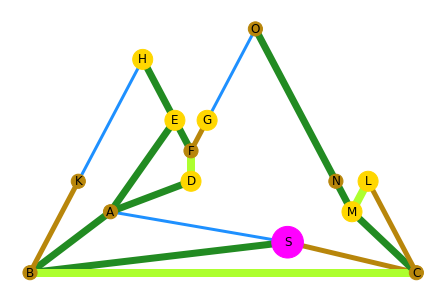

In [40]:
b.reset()
b.render() 

Take Orso by its paws and go for a few steps:

Episode:    3   Step:    1  S --1-> B R=-0.02 totalR=-0.02 cost= 100 customerR=   0 optimum=6000


c:\dev\github\easyagents\env\lib\site-packages\networkx\drawing\layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))
c:\dev\github\easyagents\env\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
c:\dev\github\easyagents\env\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


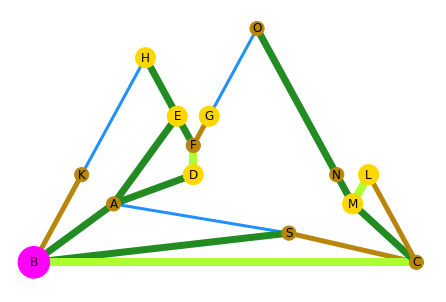

In [41]:
b.step(1)
print(b.render(mode='ansi'))
b.render()

Episode:    3   Step:    2  B --2-> C R=-0.01 totalR=-0.03 cost=  50 customerR=   0 optimum=6000


c:\dev\github\easyagents\env\lib\site-packages\networkx\drawing\layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))
c:\dev\github\easyagents\env\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
c:\dev\github\easyagents\env\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


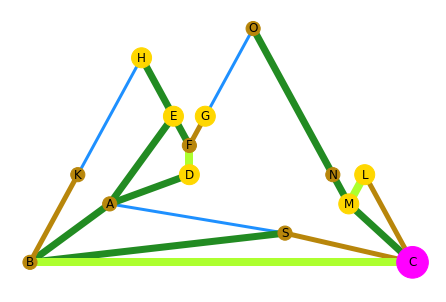

In [42]:
b.step(2)
print(b.render(mode='ansi'))
b.render()

Episode:    3   Step:    3  C --3-> L R= 0.13 totalR= 0.11 cost= 200 customerR=1000 optimum=6000


c:\dev\github\easyagents\env\lib\site-packages\networkx\drawing\layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))
c:\dev\github\easyagents\env\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
c:\dev\github\easyagents\env\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


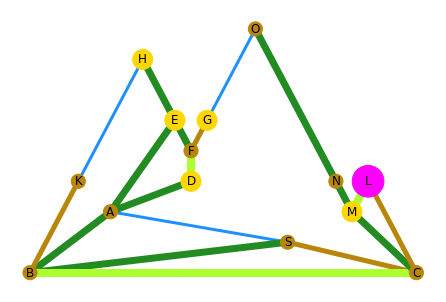

In [43]:
b.step(3)
print(b.render(mode='ansi'))
b.render()

Now Orso must start to learn by him self to take actions, memorize the geography of its neighbourhood and 
to look for honey while minimizing the effort:

# Train policy with tfagents PpoAgent

### Register with OpenAI Gym

In [36]:
if not 'isEnvRegistered' in locals():
  env_name="Berater-v1"
  gym.envs.registration.register(id=env_name,entry_point=BeraterEnv,max_episode_steps=1000)
  isEnvRegistered=True
  print("Berater registered as '" + env_name + "'")
else:
  print("Already registered")

Already registered


##  Dry run (short training, no logging)

In [30]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDurationFast
from easyagents.config import LoggingSilent

In [31]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',                        
                        training_duration=TrainingDurationFast(),
                        logging=LoggingSilent())
ppoAgent.train()

### Visualize training performance

In [32]:
ppoAgent.plot_average_rewards()

In [33]:
ppoAgent.plot_average_steps()

In [34]:
ppoAgent.plot_losses()

## Some training & logging (default, on custom network)

In [13]:
from easyagents.tfagents import PpoAgent

In [ ]:
ppoAgent = PpoAgent( gym_env_name = 'Berater-v1', fc_layers=(500,500,500) )
ppoAgent.train()

### Visualize

In [ ]:
ppoAgent.plot_average_rewards()

In [ ]:
ppoAgent.plot_average_steps()

In [ ]:
ppoAgent.plot_losses()

## Custom training (duration, learning rate)

In [112]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDuration

In [ ]:
training_duration=TrainingDuration( num_iterations = 5000,
                                    num_episodes_per_iteration = 10,
                                    max_steps_per_episode = 50,
                                    num_epochs_per_iteration = 5 )

In [ ]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',
                        fc_layers=(500,500,500), 
                        training_duration=training_duration,
                        learning_rate=1e-4
                   )
ppoAgent.train()

### Visualize (with custom y-limits)

In [ ]:
ppoAgent.plot_average_rewards(ylim=[-2,1])

In [ ]:
ppoAgent.plot_average_steps(ylim=[0,210])

In [ ]:
ppoAgent.plot_losses(ylim=[0,500])

In [22]:
ppoAgent.render_episodes()

In [115]:
from IPython.display import HTML

HTML( ppoAgent.render_episodes_to_html(num_episodes=1, fps=1) )
